In [22]:
import pandas as pd
import numpy as np

In dieser Übung soll ein Klassifikator zur Vorhersage, ob ein Titanic-Passagier überlebt hat oder nicht, implementiert werden.

#### Einlesen des Titanic-Datensatzes

In [23]:
df = pd.read_csv('titanic.csv', usecols = ['pclass', 'survived','name','sex','age','fare'])

In [24]:
df.head()

,pclass,survived,name,sex,age,fare
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,211.3375
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,151.5500
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,151.5500
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,151.5500
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,151.5500


#### Train-Test-Split

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.3, random_state=0)
X_train = X_train.copy()
X_test = X_test.copy()
y_train = X_train['survived']
y_test = X_test['survived']
X_train = X_train.drop('survived', axis=1)
X_test = X_test.drop('survived', axis=1)

## Aufgabe 1

#### a) Fehlende Werte

Ermitteln Sie alle Spalten des DataFrame **df**, in denen es fehlende Werte gibt.

In [26]:
df.columns[df.isnull().any()]

Index(['age', 'fare'], dtype='object')

Arbeiten Sie bis einschließlich Teilaufgabe g) nur auf dem Trainingsdatensatz weiter.

#### b) Feature-Engineering

Extrahieren Sie aus der Spalte **name** die Anrede des Passagiers als weiteres Feature und speichern Sie diese in einer neuen Spalte namens **title**. Verwenden Sie dazu die Methode <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.extract.html">pandas.Series.str.extract</a> und einen regulären Ausdruck. Entfernen Sie anschließend die Spalte **name** aus dem DataFrame.

In [27]:
X_train["title"] = df['name'].str.extract(r'([A-Za-z]+)\.')
X_train = X_train.drop('name', axis = 1)

In [28]:
X_train.head()

,pclass,sex,age,fare,title
501,2,female,13.0,19.5000,Miss
588,2,female,4.0,23.0000,Miss
402,2,female,30.0,13.8583,Miss
1193,3,male,NaN,7.7250,Mr
686,3,female,22.0,7.7250,Miss


#### c) Datentransformation

Transformieren Sie die Spalte **sex**, indem Sie "male" durch "0" und "female" durch "1" ersetzen.

In [29]:
X_train['sex'] = df['sex'].replace({'male': 0, 'female': 1})
X_train.head()

,pclass,sex,age,fare,title
501,2,1,13.0,19.5000,Miss
588,2,1,4.0,23.0000,Miss
402,2,1,30.0,13.8583,Miss
1193,3,0,NaN,7.7250,Mr
686,3,1,22.0,7.7250,Miss


#### d) Imputation

Ersetzen Sie unter Verwendung der Klasse <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">SimpleImputer</a> fehlende Werte in den Spalten **age** und **fare** durch die jeweiligen Spaltenmittelwerte. 

In [30]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train[['age', 'fare']] = imputer.fit_transform(X_train[['age', 'fare']])
X_train.head()

,pclass,sex,age,fare,title
501,2,1,13.000000,19.5000,Miss
588,2,1,4.000000,23.0000,Miss
402,2,1,30.000000,13.8583,Miss
1193,3,0,30.231444,7.7250,Mr
686,3,1,22.000000,7.7250,Miss


#### e) One Hot Encoding

Transformieren Sie die Spalte **title**, indem Sie alle Werte, die nicht zu
den vier häufigsten Ausprägungen gehören, durch "other" ersetzen. Erzeugen Sie anschließend
durch One Hot Encoding für jede Ausprägung von **title** eine neue Spalte, in der binär kodiert ist,
ob bei einem Passagier die jeweilige Ausprägung vorliegt oder nicht. Entfernen Sie anschließend die Spalte **title**.

Hinweise: pandas.where, pandas.get_dummies

In [31]:
top_titles = X_train['title'].value_counts().nlargest(4).index
X_train['title'] = X_train['title'].where(X_train['title'].isin(top_titles), 'other')

title_dummies = pd.get_dummies(X_train['title'], prefix='title')

# Hinzufügen der neuen Spalten zum DataFrame
X_train = pd.concat([X_train, title_dummies], axis=1)

# Entfernen der ursprünglichen "title"-Spalte
X_train = X_train.drop('title', axis=1)

In [32]:
X_train.head()

,pclass,sex,age,fare,title_Master,title_Miss,title_Mr,title_Mrs,title_other
501,2,1,13.000000,19.5000,False,True,False,False,False
588,2,1,4.000000,23.0000,False,True,False,False,False
402,2,1,30.000000,13.8583,False,True,False,False,False
1193,3,0,30.231444,7.7250,False,False,True,False,False
686,3,1,22.000000,7.7250,False,True,False,False,False


#### f) Modelltraining

Trainieren Sie auf dem Trainingsdatensatz ein logistisches Regressionsmodell.

In [33]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(random_state=0, max_iter=4000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=4000, random_state=0)

#### g) Güte des Modells auf dem Trainingsdatensatz

Bestimmen Sie die Accuracy und den ROC-AUC-Score auf dem Trainingsdatensatz.

Training Accuracy: 0.7914847161572053
ROC score training: 0.8439360165845656


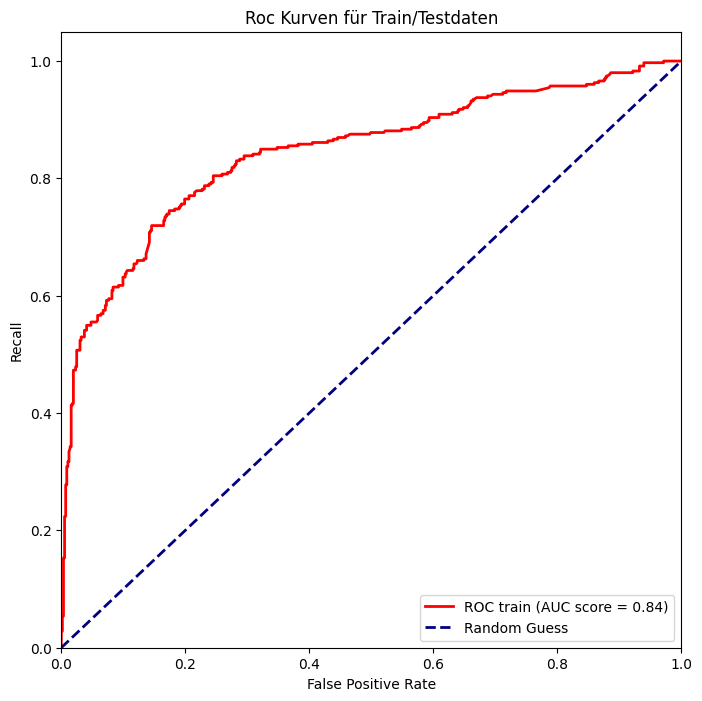

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print(f"Training Accuracy: {model.score(X_train, y_train)}")

proba_train = model.predict_proba(X_train)[:,1]

roc_train = roc_auc_score(y_train, proba_train)

print("ROC score training: {}".format(roc_train))

fpr_train, tpr_train, threshold_train = roc_curve(y_train, proba_train)

plt.figure(figsize=(8, 8))

plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'ROC train (AUC score = {roc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Roc Kurven für Train/Testdaten')
plt.legend(loc="lower right")

plt.show()

#### h) Modellanwendung auf dem Testdatensatz

Wenden Sie nun das Modell auf den Testdatensatz an. Führen Sie dazu dieselben Datentransformationsschritte wie beim Trainingsdatensatz aus. Achten Sie darauf, dass Sie nur auf Information des Trainingsdatensatzes zurückgreifen (z.B. die Mittelwerte beim Imputieren oder die vier häufigsten Ausprägungen der Spalte **title**). Bestimmen Sie Accuracy und ROC-AUC-Score auf dem Testdatensatz und bewerten Sie das resultierende Modell.

In [35]:
X_test["title"] = df['name'].str.extract(r'([A-Za-z]+)\.')
X_test = X_test.drop('name', axis = 1)

X_test['sex'] = df['sex'].replace({'male': 0, 'female': 1})

imputer = SimpleImputer(strategy='mean')
X_test[['age', 'fare']] = imputer.fit_transform(X_test[['age', 'fare']])

top_titles = X_test['title'].value_counts().nlargest(4).index
X_test['title'] = X_test['title'].where(X_test['title'].isin(top_titles), 'other')

title_dummies = pd.get_dummies(X_test['title'], prefix='title')

# Hinzufügen der neuen Spalten zum DataFrame
X_test = pd.concat([X_test, title_dummies], axis=1)

# Entfernen der ursprünglichen "title"-Spalte
X_test = X_test.drop('title', axis=1)

X_test.head()

,pclass,sex,age,fare,title_Master,title_Miss,title_Mr,title_Mrs,title_other
1139,3,0,38.000000,7.8958,False,False,True,False,False
533,2,1,21.000000,21.0000,False,True,False,False,False
459,2,0,42.000000,27.0000,False,False,True,False,False
1150,3,0,29.030055,14.5000,False,False,True,False,False
393,2,0,25.000000,31.5000,False,False,True,False,False


Training Accuracy: 0.7888040712468194
ROC score training: 0.844671201814059


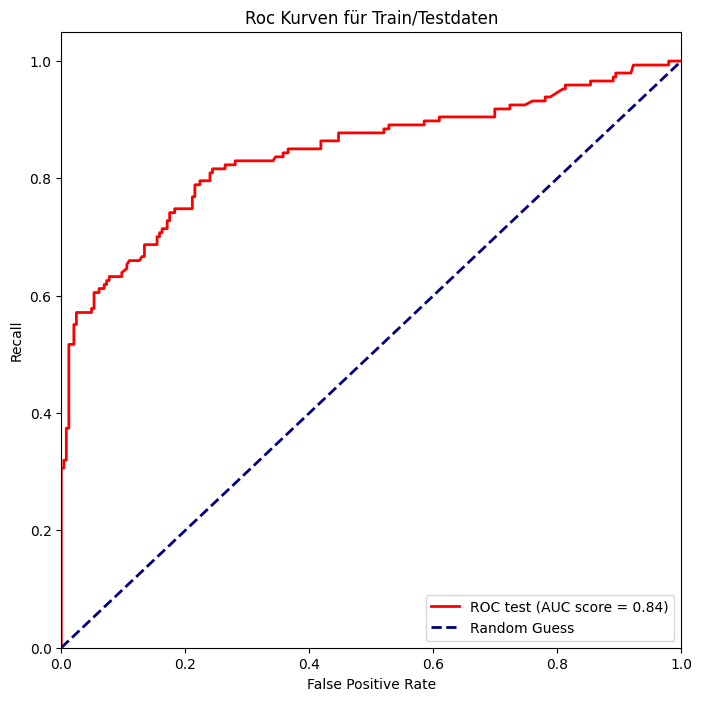

In [36]:
print(f"Training Accuracy: {model.score(X_test, y_test)}")

proba_test = model.predict_proba(X_test)[:,1]

roc_test = roc_auc_score(y_test, proba_test)

print("ROC score training: {}".format(roc_test))

fpr_test, tpr_test, threshold_test = roc_curve(y_test, proba_test)

plt.figure(figsize=(8, 8))

plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC test (AUC score = {roc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Roc Kurven für Train/Testdaten')
plt.legend(loc="lower right")

plt.show()

## Aufgabe 2

In dieser Aufgabe soll der Datentransformationsprozess und die Klassifikation mit Hilfe einer <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">Pipeline</a> realisiert werden.

#### Daten erneut einlesen

Hier wird der Datensatz erneut eingelesen und diesmal nur die Spalten **survived**, **pclass**, **sex**, **age** und **fare** beibehalten. Anschließend erfolgt der Train-Test-Split und das Abspalten der Zielvariable.

In [57]:
df = pd.read_csv('titanic.csv', usecols = ['pclass', 'survived','sex','age','fare'])
df['pclass'] = df['pclass'].astype(str)
X_train, X_test = train_test_split(df, test_size=0.3, random_state=0)
X_train = X_train.copy()
X_test = X_test.copy()
y_train = X_train['survived']
y_test = X_test['survived']
X_train = X_train.drop('survived', axis=1)
X_test = X_test.drop('survived', axis=1)

In [58]:
X_train.head()

,pclass,sex,age,fare
501,2,female,13.0,19.5000
588,2,female,4.0,23.0000
402,2,female,30.0,13.8583
1193,3,male,NaN,7.7250
686,3,female,22.0,7.7250


#### a) Eigenen Imputer schreiben

Implementieren Sie einen eigenen Imputer namens **OutlierImputer**. Dieser soll auf numerische Spalten angewendet werden und fehlende Werte in einer Spalte durch 
$x_{min}-(x_{max}-x_{min})$ ersetzen, wobei $x_{max}$ der maximale und $x_{min}$ der minimale Wert der Spalte des Trainingsdatensatzes ist. Leiten Sie Ihren Imputer von den Klassen TransformerMixin und BaseEstimator ab.

In [61]:
from sklearn.base import TransformerMixin, BaseEstimator

class OutlierImputer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        # Speichern Sie für jede Spalte den minimalen und maximalen Wert
        self.min_values_ = X.min()
        self.max_values_ = X.max()
        return self

    def transform(self, X):
        # Ersetzen Sie fehlende Werte durch x_min - (x_max - x_min)
        X_transformed = X.copy()
        for col in X.columns:
            X_transformed[col].fillna(self.min_values_[col] - (self.max_values_[col] - self.min_values_[col]), inplace=True)
        return X_transformed


#### b) ColumnTransformer und Pipeline

Mit Hilfe eines <a href="https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html">ColumnTransformers</a> können bestimmte Transformer auf Teilmengen der Datensatz-Spalten angewendet werden (z.B. die numerischen und die kategorischen).

Legen Sie einen ColumnTransformer an, der auf die numerischen Spalten den OutlierImputer aus Teilaufgabe a) und den <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> anwendet, und auf die kategorischen Spalten den <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html">SimpleImputer</a> (mit strategy='constant') und einen <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html">OneHotEncoder</a>. Legen Sie anschließend eine Pipeline an, die aus dem ColumnTransformer und einem LogisticRegression Estimator besteht. Fitten Sie die Pipeline auf dem Trainingsdatensatz und berechnen Sie Accuracy und ROC-AUC-Score auf dem Trainingsdatensatz

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features=['fare', 'age']
numeric_transformer = Pipeline(steps=[
    ('imputer', OutlierImputer()),
    ('scaler', StandardScaler())
])

categorical_features = ['sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs')
                   )]
               )
_ = clf.fit(X_train, y_train)



#### c) Modellanwendung auf dem Testdatensatz

Wenden Sie die Pipeline auf den Testdatensatz an. Berechnen Sie den ROC AUC-Score und die Accuracy für den Testdatensatz.

In [63]:
clf.score(X_train, y_train)

0.7816593886462883

In [64]:
clf.score(X_test, y_test)

0.7760814249363868